In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib

%matplotlib inline
sns.set(style = 'white', font_scale = 0.9)


import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import scikitplot as skplt

In [14]:
def classifier_mod(X_train, y_train, X_test, y_test, sampName):
    
    ## print the shape of imported dataset
    print('X_train shape: ', X_train.shape)
    print('y_train shape: ', y_train.shape)
    print('X_test shape: ', X_test.shape)
    print('y_test shape: ', y_test.shape)
    
    ## grid search for the optimal hyperparameters
    mod = lgb.LGBMClassifier(random_state = 123) 
    
    param_grid = {'max_depth': [15, 20, 25, 30],
               'num_leaves': [10, 20, 30],
              'learning_rate': [0.01, 0.1, 0.5],
              'n_estimator': [100, 200,300,400,500],
              'reg_alpha': [0.1, 0.4, 0.5, 0.6],
              'reg_lambda': [0.1, 0.4, 0.5, 0.6]}    

    
    grid = GridSearchCV(estimator = mod,
                    param_grid = param_grid,
                    scoring = 'roc_auc',
                    cv = 5,
                    n_jobs = -1,
                    verbose = 1)

    #feature 0-5 are categorical variables
    grid.fit(X_train, y_train,
              categorical_feature = [0, 15, 16, 17, 18])
    
    print(grid.best_score_)
    print(grid.best_params_)
    
    ## fit the model with the optimal hyperparameters
    classifier = lgb.LGBMClassifier(random_state = 123,
                                max_depth = grid.best_params_['max_depth'],
                                 num_leaves = grid.best_params_['num_leaves'],
                                learning_rate = grid.best_params_['learning_rate'],
                                n_estimator = grid.best_params_['n_estimator'],
                                reg_alpha = grid.best_params_['reg_alpha'],
                                reg_lambda = grid.best_params_['reg_lambda'])
    
    
    classifier.fit(X_train, y_train,
                   categorical_feature = [0,15,16,17,18])

    
    ## pickle the fitted model
    joblib.dump(classifier, 'lgbm_'+sampName+'.pkl')
    
    ## pickle the predicted responses
    y_pred = classifier.predict(X_test)
    y_pred_prob = classifier.predict_proba(X_test)
    
    joblib.dump(y_pred, 'y_pred_'+sampName+'.pkl')
    joblib.dump(y_pred_prob, 'y_pred_prob_'+sampName+'.pkl')
    
    # printout metrics for model performance
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)
    plt.savefig('confusion_matrix_lgbm.png')
    
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize = True)
    plt.savefig('confusion_matrix_lgbm_norm.png')
    
    
    print('Classification report:\n', classification_report(y_test, y_pred))
    
    print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred))
    skplt.metrics.plot_roc(y_test, y_pred_prob)
    plt.savefig('roc_lgbm.png')
    
    skplt.metrics.plot_precision_recall_curve(y_test, y_pred_prob)
    plt.savefig('pr_lgbm.png')
    
    # printout feature importances
    feature_import = pd.DataFrame(data = classifier.feature_importances_, index = X_test.columns.values, columns = ['values'])
    feature_import.sort_values(['values'], ascending = False, inplace = True)
    feature_import.reset_index(level = 0, inplace = True)
    print(feature_import)
    
    # feature importances plot
    plt.figure(figsize = (35,20))
    sns.set(style = 'white', font_scale = 2)
    
    ax = sns.barplot(x = 'values', y = 'index', data = feature_import, palette = 'deep')
    ax.set_title('Variables Imporatnce Plot of LightGBM')
    plt.savefig('importance_lgmb.png')
    
    return classifier


In [15]:
import os

os.chdir('C:/Users/LUY1/Desktop/customer churn data/data')
print(os.getcwd())

C:\Users\LUY1\Desktop\customer churn data\data


In [16]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')

y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [17]:
X_train.head()

,RENEWAL_MONTH,POL_DURATION,PREM,PY_PREM,ACDH_CLAIMS,ADEX_CLAIMS,EWNF_CLAIMS,THFT_CLAIMS,STMP_CLAIMS,FIRP_CLAIMS,FRZP_CLAIMS,OTPP_CLAIMS,SUBP_CLAIMS,OTHER_CLAIMS,TOTAL_CLAIMS,COMP,PYMT_FRQ_ACTL_B2,CUSTOMER_SEGMENT,COVER_TYPE_NUM
421661,1,4,147.53,127.92,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1
79866,2,12,218.92,322.43,0,0,0,0,0,0,0,0,0,0,0,0,3,4,1
431586,4,4,165.20,157.33,0,0,0,0,0,0,0,0,0,0,0,0,3,4,1
142020,10,7,196.90,111.31,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1
101066,9,9,151.66,144.76,0,0,0,0,0,0,0,0,0,0,0,0,3,6,1


In [18]:
os.chdir('C:/Users/LUY1/Desktop/customer churn data/models')
print(os.getcwd())

C:\Users\LUY1\Desktop\customer churn data\models


X_train shape:  (419420, 19)
y_train shape:  (419420,)
X_test shape:  (104855, 19)
y_test shape:  (104855,)
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 115.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 161.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 217.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 290.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 372.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 471.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 567.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 734.8min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 847.2min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 964.9min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | elapsed: 1058.8min
[Parallel(n_jobs=-1)]: Done 12792 tasks      |

0.7053535278130765
{'learning_rate': 0.1, 'max_depth': 25, 'n_estimator': 100, 'num_leaves': 30, 'reg_alpha': 0.5, 'reg_lambda': 0.1}


C:\Users\LUY1\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 15, 16, 17, 18]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\LUY1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy score:  0.8598254732726146
Confusion matrix:
 [[  711 14258]
 [  440 89446]]


C:\Users\LUY1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\LUY1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Classification report:
              precision    recall  f1-score   support

          0       0.62      0.05      0.09     14969
          1       0.86      1.00      0.92     89886

avg / total       0.83      0.86      0.80    104855

ROC_AUC_score:  0.5213015367672753


C:\Users\LUY1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


               index  values
0               PREM     934
1            PY_PREM     871
2      RENEWAL_MONTH     271
3       POL_DURATION     238
4   CUSTOMER_SEGMENT     190
5   PYMT_FRQ_ACTL_B2     142
6     COVER_TYPE_NUM     142
7       TOTAL_CLAIMS      36
8        EWNF_CLAIMS      20
9        THFT_CLAIMS      13
10       ADEX_CLAIMS      12
11       ACDH_CLAIMS       9
12       FRZP_CLAIMS       7
13       FIRP_CLAIMS       6
14       SUBP_CLAIMS       3
15       STMP_CLAIMS       2
16       OTPP_CLAIMS       2
17              COMP       2
18      OTHER_CLAIMS       0


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=25, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimator=100,
        n_estimators=100, n_jobs=-1, num_leaves=30, objective=None,
        random_state=123, reg_alpha=0.5, reg_lambda=0.1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

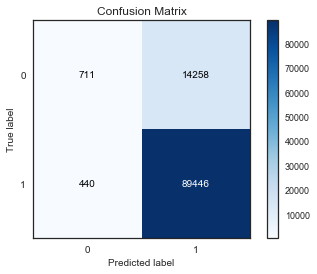

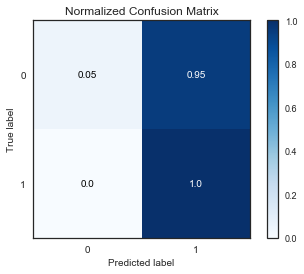

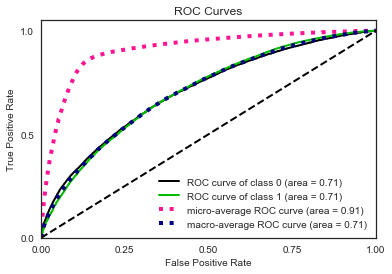

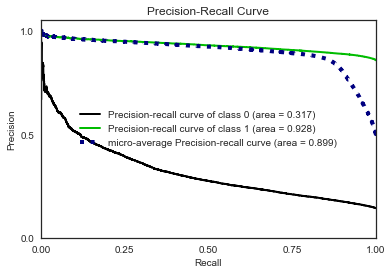

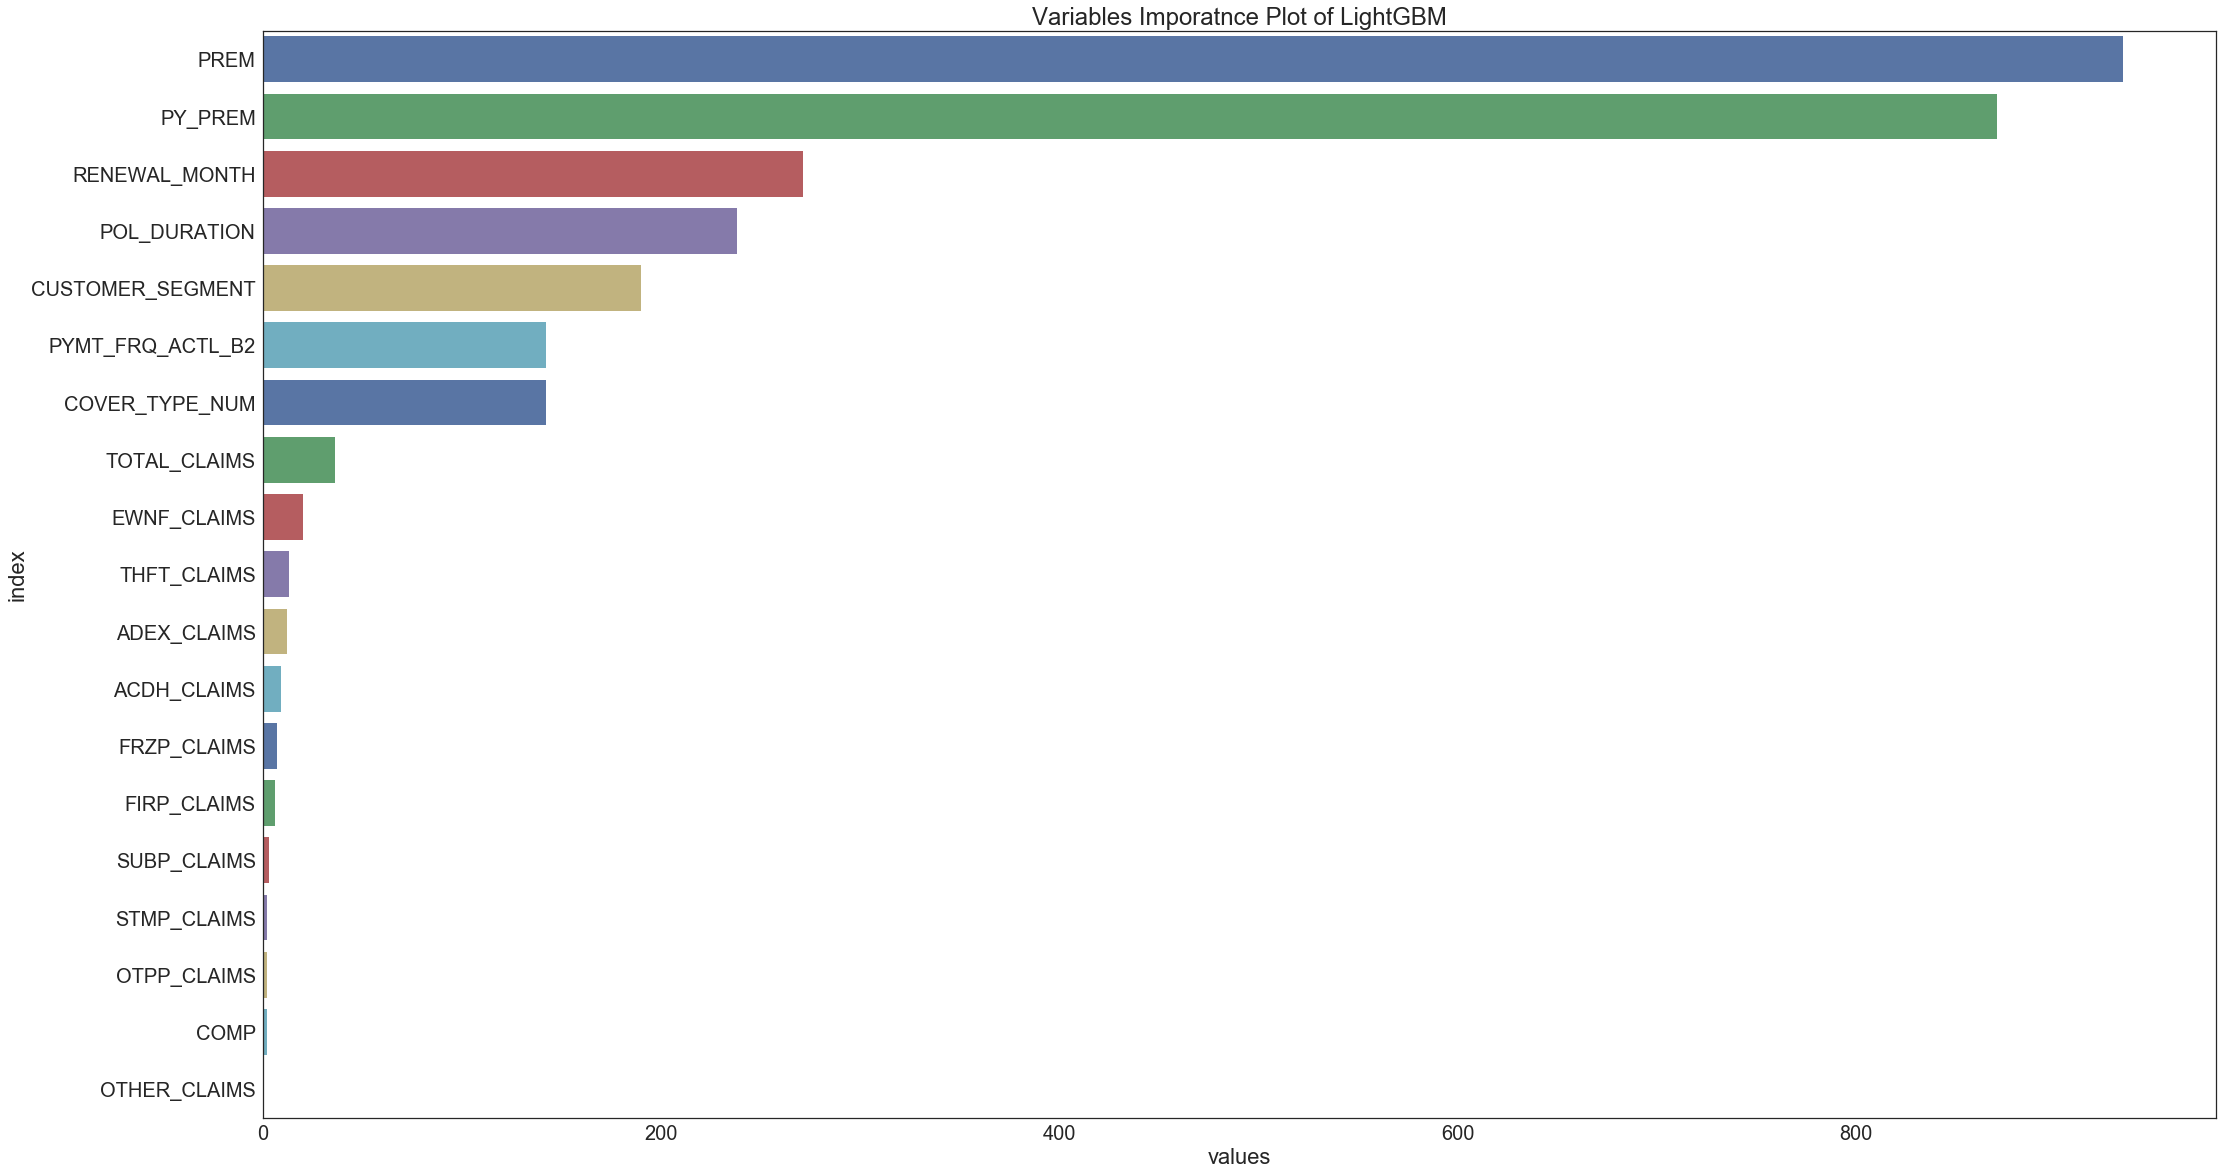

In [19]:
classifier_mod(X_train, y_train, X_test, y_test, 'nosamp')